In [1]:
import numpy
from IPython.display import clear_output
import time

In [2]:
#Function 
def func(x,y):
    f = np.exp(-0.2*(x**4+y**4))+np.exp(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))
    return f
#func(0,0)
def decoding_x(binValue):
    binValue = "".join(str(x) for x in binValue.tolist())
    valhat = int(binValue, 2)
    realvalue= (((3)/((2**15)-1))*valhat)-1
    return realvalue

def decoding_y(binValue):
    binValue = "".join(str(x) for x in binValue.tolist())
    valhat = int(binValue, 2)
    realvalue= (((3)/((2**15)-1))*valhat)-2
    return realvalue

def fitnes(pop):
    rslt = np.zeros([sol_per_pop,1])
    for x in range(pop.shape[0]):
        rslt[x] = func(decoding_x(pop[x,0,:]),decoding_y(pop[x,1,:]))
    return rslt

In [3]:
#Creating the initial population. (With Constraint)
def initpop():
    new_pop = np.array([np.random.randint(2,size=15)])
    new_pop = np.append([new_pop],[new_pop],axis=1)
    while(True):
        if new_pop.shape[0]>pop_size[0]+1:
            break
        else:
            binx = np.random.randint(2, size=15)
            biny = np.random.randint(2, size=15)
            #check
            decx = decoding_x(binx)
            decy = decoding_y(biny)
            if decx+decy<=1:
                newCrom = np.append([np.array([binx])],[np.array([biny])],axis=1)
                new_pop = np.append(new_pop,newCrom,axis=0)
    new_pop = new_pop[2:,:,:]
    return new_pop

In [4]:
#Roulete Wheel Selection
def selection(fitness,pop,num_parents_mating):
    fsum = np.sum(fitness)
    #normalization
    pfit = fitness/fsum
    #pfit = (fitness - np.min(fitness))/np.ptp(fitness)
    cump = np.cumsum(pfit)
    index = []
    while(1):
        r = np.random.uniform(low=0,high=1,size=(2,))
        ind = cump.searchsorted(r)
        if len(index)>=sol_per_pop:
            break
        if (np.array_equal(ind[0],ind[1])):
            continue
        else:
            index = np.append(index,ind)

    select = index.astype(int)
    selected = new_pop[select,:,:]
    return selected

In [5]:
#Mutation & CrossOver
def crossmut(parents,cr,mr,num_parents_mating):
    n = np.empty([1,2,15])
    for a in range(0, parents.shape[0], 2):
        chrom1 = parents[a,:,:]
        chrom2 = parents[a+1,:,:]
        #crossover?
        if (genProb()<cr):
            #where?
            loc = int(genProb()*(bitsreq-1))
            #do crossover
            xnc1 = np.append(chrom1[0][0:loc],chrom2[0][loc:int(bitsreq)])
            xnc1 = mutate(xnc1,mr)
            xnc2 = np.append(chrom2[0][0:loc],chrom1[0][loc:int(bitsreq)])
            xnc2 = mutate(xnc2,mr)
            ync1 = np.append(chrom1[1][0:loc],chrom2[1][loc:int(bitsreq)])
            ync1 = mutate(ync1,mr)
            ync2 = np.append(chrom2[1][0:loc],chrom1[1][loc:int(bitsreq)])
            ync2 = mutate(ync2,mr)
            #make new pop
            nc1 = np.append([xnc1],[ync1],axis=0)
            nc2 = np.append([xnc2],[ync2],axis=0)
            #append
            n = np.append(n,[nc1],axis=0)
            n = np.append(n,[nc2],axis=0)
        else:
            #check mutation
            chrom1[0,] = mutate(chrom1[0,],mr)
            chrom1[1,] = mutate(chrom1[1,],mr)
            chrom2[0,] = mutate(chrom2[0,],mr)
            chrom2[1,] = mutate(chrom2[1,],mr)

            n = np.append(n,[chrom1],axis=0)
            n = np.append(n,[chrom2],axis=0)
    new_gen = n[1:,:,:].astype(int)
    return new_gen

In [6]:
#Probability Check
def genProb():
    value = np.random.uniform(low=0,high=1,size=(1,))
    return value[0]

#Mutation Check
def mutate(chrmori,mr):
    if genProb()<mr:
        loc = int(genProb()*(bitsreq-1))
        chrmori[loc] = np.logical_not(chrmori[loc]).astype(int)
        return chrmori
    else:
        return chrmori

# Constraint Penalty
# Static Penalty 
# rank 1 1<x+y<2, rank 2 2<x+y<4, rank 3 4<x+y<8, rank 4 8<x+y<16, rank 5 16<x+y<32 
def staticPenalty(fitness,population):
    for x in range(population.shape[0]):
        rslt = decoding_x(population[x,0,:])+decoding_y(population[x,1,:])
        if rslt>1:
            rank_pen = np.ceil(np.log(rslt)/np.log(2))
            fitness[x] = fitness[x] - (rank_pen*((np.abs(rslt-1))**2))
    return fitness

In [7]:
#Parameter GA
sol_per_pop = 50
# Number of the weights we are looking to optimize.
num_weights = 2
# Defining the population size.
# The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
pop_size = (sol_per_pop,num_weights)
# bits required
xbits,ybits,decimals  = 3,3,4
coveredVal = (xbits)*(10**decimals)
bitsreq = np.ceil(np.log(coveredVal)/np.log(2))
print(bitsreq)

15.0


In [8]:
best_params = []
best_out = 0
best_outputs = []
num_generations = 10000
new_pop = initpop()

In [11]:
start_time = time.time()
for generation in range(num_generations+1):
    
    # Measuring the fitness of each chromosome in the population.
    fitness = fitnes(new_pop)
    # Penalties
    fitness = staticPenalty(fitness,new_pop)
    
    best_outputs= np.append(best_outputs,np.max(fitness))
    if np.max(fitness)>best_out:
        index = generation
        best_params = new_pop[np.argmax(fitness),:,:]
        best_out = np.max(fitness)
    # Selecting the best parents in the population for mating.
    parents = selection(fitness,new_pop,4)

    genx = crossmut(parents,0.9,0.2,4)
    new_pop = genx
#     if (generation % 100) == 0:
#         print('Generation : {} Best Outputs : {}'.format(generation, np.max(fitness)))
        

print("--- %s seconds ---" % (time.time() - start_time))

--- 17.508861303329468 seconds ---


In [10]:
#best output every iteration
best_iter = []
#best_iter = np.append(best_iter,0)
best_iter = np.append(best_iter,best_outputs[0])
for i in range (1,best_outputs.shape[0]):
    if (best_outputs[i]>best_iter[i-1]):
        best_iter =  np.append(best_iter,best_outputs[i])
    else:
        best_iter =  np.append(best_iter,best_iter[i-1])

In [11]:
decx = decoding_x(best_params[0])
decy = decoding_y(best_params[1])

In [19]:
print("Maximum Value Values {:.6f}".format(best_outputs.max()))
print("X Values {:.4f}".format(decx))
print("Y Values {:.4f}".format(decy))

Maximum Value Values 8.389040
X Values -0.0003
Y Values 0.0001


In [14]:
# Plotting Maximum value each iteration
import matplotlib.pyplot as plt

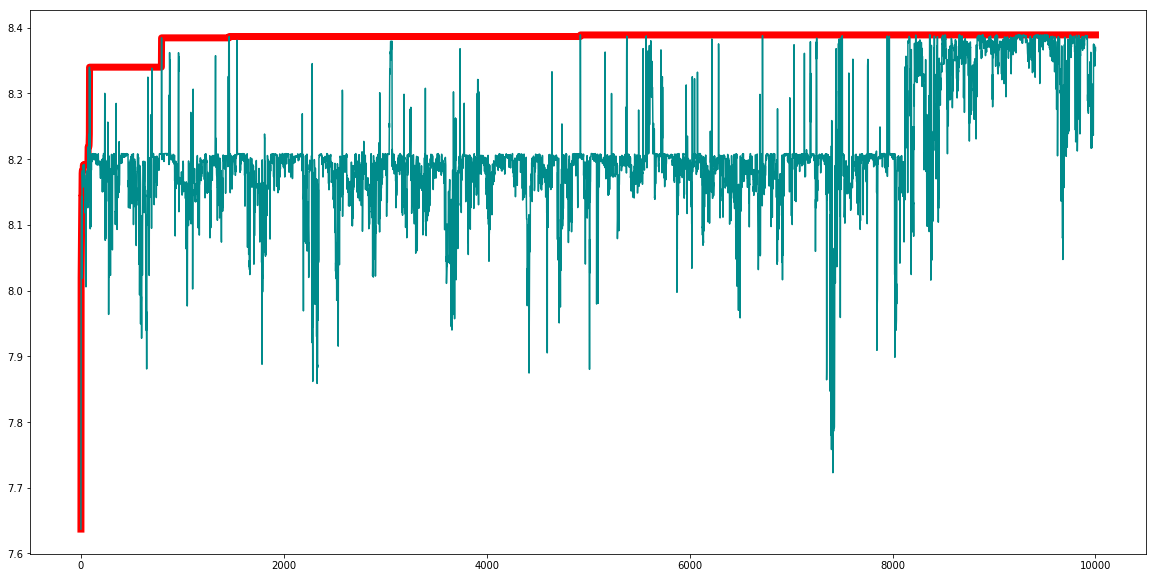

In [15]:
x = np.arange(best_outputs.shape[0])
plt.figure(figsize=(20,10))
plt.plot(x,best_iter,c='r',linewidth=7.0)
plt.plot(x,best_outputs,c='darkcyan')
plt.show()

In [20]:
#Eror percentage
maximum = func(0,0)
realout = func(decx,decy)
print("Maximum Point {:.8f}".format(maximum))
print("System Maximum Point {:.8f}".format(realout))
err = (maximum-realout)/maximum *100
print("Error Percentage {:.4f}".format(err))

Maximum Point 8.38905610
System Maximum Point 8.38904034
Error Percentage 0.0002


In [21]:
maximum= func(0,0)
while(True):
    
    # Measuring the fitness of each chromosome in the population.
    fitness = fitnes(new_pop)
    # Penalties
    fitness = staticPenalty(fitness,new_pop)
    
    best_outputs= np.append(best_outputs,np.max(fitness))
    if np.max(fitness)>best_out:
        index = generation
        best_params = new_pop[np.argmax(fitness),:,:]
        best_out = np.max(fitness)
    # Selecting the best parents in the population for mating.
    parents = selection(fitness,new_pop,4)

    genx = crossmut(parents,0.9,0.2,4)
    new_pop = genx
    err = (maximum-realout)/maximum *100
    if (generation % 100) == 0:
        print('Generation : {} Best Outputs : {}'.format(generation, np.max(fitness)))
    
    if err<0.01:
        break